# scQuint Data Preprocessing PBMC copy

In [32]:
##processing pipeline of cellxSJ matric StarSolo output for use with scQuint. Scripts by Gonzalo Benegas

In [1]:
!date

Tue Sep 10 02:16:10 PDT 2024


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [3]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
from umap import UMAP

from scquint.data import add_gene_annotation, group_introns, load_adata_from_starsolo, filter_singletons

from scquint.data import calculate_PSI

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
input_dir = output_dir = '/c4/home/derek/data1/derek/data_scSLR/PBMC/'
os.makedirs(output_dir, exist_ok=True)

### Load Gene Expression Anndata

In [5]:
# we will extract obs and X_umap
adata_exp = anndata.read_h5ad(input_dir+'gene_expression_v2.h5ad')
adata_exp

AnnData object with n_obs × n_vars = 19087 × 18450
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'feature_types', 'ge

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


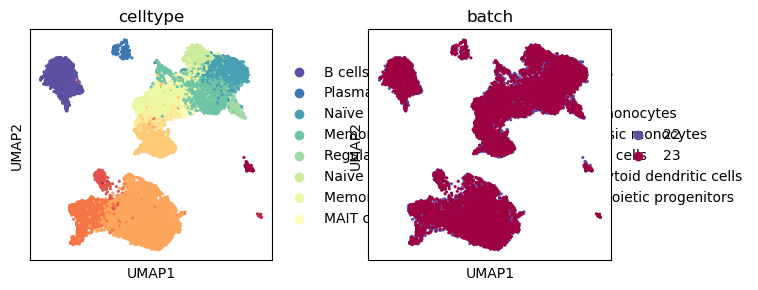

In [6]:
plt.rcParams['figure.figsize'] = 3,3

sc.pl.umap(adata_exp,
           color=['celltype','batch'],
           palette='Spectral_r',
           size=20,
        #   legend_loc='on data'
           
          )

In [7]:
##fix obs names
# adata_exp.obs_names = adata_exp.obs_names.str.replace('-1-22','-0').str.replace('-1-23','-1')

In [8]:
#when process single sample 2 
# adata_exp = adata_exp[adata_exp.obs.batch == '23']

### Load Splice Junction Matricies into scQuint

In [9]:
input_dir = '/c4/home/derek/data1/derek/data_scSLR/immune_fastqs/'

In [11]:
adatas_spl = {}
samples = ["sample_1",
            "sample_2"
          ]
for sample in samples:
    print(sample)
    try:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/STAR_outs/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    except:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/STAR_outs/Solo.out/SJ/raw/", var_filename="features.tsv")
    adatas_spl[sample] = adata_spl_sample

sample_1
Filtering out undefined strand.
sample_2
Filtering out undefined strand.


In [12]:
adata_spl = anndata.concat(adatas_spl, index_unique="-", merge="same")
adata_spl

AnnData object with n_obs × n_vars = 1474560 × 418124
    var: 'chromosome', 'start', 'end', 'strand', 'intron_motif'

In [13]:
##fix obs names
adata_spl.obs_names = adata_spl.obs_names.str.replace('-sample_1','-0').str.replace('-sample_2','-1')

In [14]:
adata_exp.obs_names

Index(['AAACCTGAGATATGCA-0', 'AAACCTGAGCTGATAA-0', 'AAACCTGAGGTCGGAT-0',
       'AAACCTGAGTACGTTC-0', 'AAACCTGAGTCAAGCG-0', 'AAACCTGAGTCGCCGT-0',
       'AAACCTGAGTTGCAGG-0', 'AAACCTGAGTTGTAGA-0', 'AAACCTGCAACAACCT-0',
       'AAACCTGCAACACCCG-0',
       ...
       'TTTGTCACAGTTCATG-1', 'TTTGTCAGTAGAAGGA-1', 'TTTGTCAGTCTTGTCC-1',
       'TTTGTCAGTCTTTCAT-1', 'TTTGTCAGTGCAGGTA-1', 'TTTGTCAGTGTTGAGG-1',
       'TTTGTCAGTTGGACCC-1', 'TTTGTCAGTTGTACAC-1', 'TTTGTCATCCGGGTGT-1',
       'TTTGTCATCTACTATC-1'],
      dtype='object', name='barcode_index', length=19087)

In [15]:
adata_spl = adata_spl[adata_spl.obs_names.isin(adata_exp.obs_names)]
adata_exp = adata_exp[adata_exp.obs_names.isin(adata_spl.obs_names)]

In [16]:
adata_spl.obs = adata_exp.obs
adata_spl.obsm["X_umap"] = adata_exp.obsm["X_umap"]
adata_spl

AnnData object with n_obs × n_vars = 19087 × 418124
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'star

# Filter splice juntions 

In [17]:
%%time

SJ_table = {}

samples = ["sample_1",
            "sample_2"
          ]
for sample in samples:
    print(sample)
    try:
        SJ_table_sample = pd.read_csv(input_dir+f"{sample}/merged/merged_sjdb.tab",sep='\t',header=None,
                            names=['chromosome','start','end','strand','intron_motif','annotated','coverage','multi_map_coverage','max_ovehang'])
    except:
        SJ_table_sample = pd.read_csv(input_dir+f"/{sample}/STAR_outs/SJ.out.tab",sep='\t',header=None,
                            names=['chromosome','start','end','strand','intron_motif','annotated','coverage','multi_map_coverage','max_ovehang'])
        
    
    SJ_table[sample] = SJ_table_sample

sample_1
sample_2
CPU times: user 2.92 s, sys: 411 ms, total: 3.33 s
Wall time: 3.82 s


In [18]:
SJ_table_df = pd.concat(SJ_table.values(), ignore_index=True)

SJ_table_df = SJ_table_df.groupby(['chromosome','start','end','strand','intron_motif','annotated']).agg({'coverage':'sum', 
                         'multi_map_coverage':'max', 
                         'max_ovehang':'max',})  

SJ_table_df=SJ_table_df.reset_index()

SJ_table_df_bac = SJ_table_df.copy()

SJ_table_df = SJ_table_df[SJ_table_df['coverage'] >= 50]

SJ_table_df.index = SJ_table_df['chromosome']+':'+SJ_table_df['start'].astype(str)+'-'+SJ_table_df['end'].astype(str)

In [20]:
SJ_table_df.shape

(208282, 9)

In [20]:
SJ_table_df.shape

(206785, 9)

In [21]:
adata_spl = adata_spl[:,adata_spl.var_names.isin(SJ_table_df.index)]

In [22]:
adata_spl

View of AnnData object with n_obs × n_vars = 19087 × 206736
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome

In [23]:
sc.pp.filter_genes(adata_spl, min_cells=1)
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
adata_spl = adata_spl[:, adata_spl.var.chromosome.isin(chromosomes)]

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [24]:
adata_spl.shape

(19087, 198907)

In [25]:
%%time
##add annotations

gtf_path = '/c4/home/derek/data1/derek/reference/human_hp3_reference/genes/genes.gtf'
filter_unique_gene=True
    
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    header=None,
    comment="#",
    names=[
        "chromosome",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

gtf = gtf[gtf.feature == "exon"]
gtf["gene_id"] = gtf.attribute.str.extract(r'gene_id "([^;]*)";')
gtf["gene_name"] = gtf.attribute.str.extract(r'gene_name "([^;]*)";')
#gtf.chromosome = "chr" + gtf.chromosome.astype(str)

gene_id_name = gtf[["gene_id", "gene_name"]].drop_duplicates()

exon_starts = (
    gtf[["chromosome", "start", "gene_id"]].copy().rename(columns={"start": "pos"})
)
exon_starts.pos -= 1
exon_ends = (
    gtf[["chromosome", "end", "gene_id"]].copy().rename(columns={"end": "pos"})
)
exon_ends.pos += 1
exon_boundaries = pd.concat(
    [exon_starts, exon_ends], ignore_index=True
).drop_duplicates()

genes_by_exon_boundary = exon_boundaries.groupby(
    ["chromosome", "pos"]
).gene_id.unique()

adata_spl.var = (
    adata_spl.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "start"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_start"})
    .set_index(adata_spl.var.index)
)
adata_spl.var = (
    adata_spl.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "end"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_end"})
    .set_index(adata_spl.var.index)
)

def fill_na_with_empty_array(val):
    return val if isinstance(val, np.ndarray) else np.array([])

adata_spl.var.gene_id_start = adata_spl.var.gene_id_start.apply(fill_na_with_empty_array)
adata_spl.var.gene_id_end = adata_spl.var.gene_id_end.apply(fill_na_with_empty_array)

adata_spl.var["gene_id_list"] = adata_spl.var.apply(
    lambda row: np.unique(np.concatenate([row.gene_id_start, row.gene_id_end])),
    axis=1,
)
adata_spl.var["n_genes"] = adata_spl.var.gene_id_list.apply(len)
adata_spl.var.gene_id_list = adata_spl.var.gene_id_list.apply(
    lambda x: ",".join(x.tolist())
)
adata_spl.var.gene_id_start = adata_spl.var.gene_id_start.apply(
    lambda x: ",".join(x.tolist())
)
adata_spl.var.gene_id_end = adata_spl.var.gene_id_end.apply(
    lambda x: ",".join(x.tolist())
)

if filter_unique_gene:
    print("Filtering to introns associated to 1 and only 1 gene.")
    adata_spl = adata_spl[:, adata_spl.var.n_genes == 1]
    adata_spl.var["gene_id"] = adata_spl.var.gene_id_list
    adata_spl.var.drop(columns=["gene_id_list",], inplace=True)
    adata_spl.var = adata_spl.var.merge(gene_id_name, how="left", on="gene_id").set_index(
        adata_spl.var.index
    )
    adata_spl.var.index = adata_spl.var.gene_name.astype(str) + "_" + adata_spl.var.index.astype(str)




Filtering to introns associated to 1 and only 1 gene.


<timed exec>:92: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


CPU times: user 3min 5s, sys: 8.09 s, total: 3min 13s
Wall time: 3min 20s


### group introns by 3' and 5'

In [26]:
def group_introns(adata, by="three_prime", filter_unique_gene_per_group=True):
    if by == "three_prime":
        adata.var["intron_group"] = adata.var.apply(
            lambda intron: intron.chromosome
            + "_"
            + (str(intron.end) if intron.strand == "+" else str(intron.start))
            + "_"
            + intron.strand,
            axis=1,
        )
    elif by == "five_prime":
        adata.var["intron_group"] = adata.var.apply(
            lambda intron: intron.chromosome
            + "_"
            + (str(intron.start) if intron.strand == "+" else str(intron.end))
            + "_"
            + intron.strand,
            axis=1,
        )
    elif by == "gene":
        adata.var["intron_group"] = adata.var.gene_id
    else:
        raise Exception(f"Grouping by {by} not yet supported.")

    intron_group_sizes = (
        adata.var.intron_group.value_counts()
        .to_frame()
        .rename(columns={"intron_group": "intron_group_size"})
    )
    adata.var = adata.var.merge(
        intron_group_sizes, how="left", left_on="intron_group", right_index=True
    ).set_index(adata.var.index)
    print("Filtering singletons.")
    adata = adata[:, adata.var.intron_group_size > 1]


    if filter_unique_gene_per_group:
        print("Filtering intron groups associated with more than 1 gene.")
        n_genes_per_intron_group = adata.var.groupby("intron_group").gene_id.nunique().to_frame().rename(columns={"gene_id": "n_genes_per_intron_group"})
        adata.var = adata.var.merge(n_genes_per_intron_group, how="left", left_on="intron_group", right_index=True)
        adata = adata[:, adata.var.n_genes_per_intron_group==1]
        adata.var.intron_group = adata.var.gene_name.astype(str) + "_" + adata.var.intron_group.astype(str)

    return adata

In [27]:
adata_spl_3p = group_introns(adata_spl.copy(), by="three_prime")
adata_spl_3p.var["grouping"] = "three_prime"
adata_spl_3p

Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 19087 × 70916
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'start

In [28]:
adata_spl_5p = group_introns(adata_spl.copy(), by="five_prime")
adata_spl_5p.var["grouping"] = "five_prime"
adata_spl_5p

Filtering singletons.
Filtering intron groups associated with more than 1 gene.


/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


AnnData object with n_obs × n_vars = 19087 × 74568
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'start

# combine 3p and 5p groupings

### keep groups with greater cell coverage

In [29]:
%%time

var_concat = pd.concat([adata_spl_3p.var, adata_spl_5p.var])

direction_dict = {}


for intron in var_concat[var_concat.index.duplicated()].index.unique():

    pair = var_concat[var_concat.index == intron]
    
    count_dict={}
    for intron_group in pair.intron_group:
        n_cells = var_concat[var_concat.intron_group == intron_group].n_cells.sum()
        direction = pair[pair.intron_group == intron_group].grouping[0]

        count_dict[intron_group] = n_cells
        direction_dict[intron_group] = direction
    
    
    #keep introns that exist in directional group with higher cell counts
    keep = max(count_dict,key=count_dict.get)
    direction = direction_dict[keep]
    
    
    direction_dict[intron] = direction
    
    
#     if direction == 'five_prime':
#         direction_dict[intron] = 'five_prime'
        
#     elif direction == 'three_prime':
#         direction_dict[intron] = 'three_prime'



# var_concat = pd.concat([adata_spl_3p.var, adata_spl_5p.var])



# keep_5p = var_concat[~var_concat.index.duplicated()].query('grouping == "five_prime"').index.values


# adata_spl__ = anndata.concat(
#     [adata_spl_3p, adata_spl_5p[:, keep_5p]],
#     axis=1,
#     merge="same",
# )
# adata_spl__

CPU times: user 41min 28s, sys: 5.24 s, total: 41min 34s
Wall time: 41min 50s


In [30]:
%%time 
df=var_concat[var_concat.index.duplicated(False)]#.index.unique()

df_ = pd.DataFrame()

for index, row in df.iterrows():
    if row.grouping == direction_dict[index]:
        row=pd.DataFrame(row).T
        
        df_ = pd.concat([df_,row])
        
keep__5p_nondups = var_concat[~var_concat.index.duplicated(keep=False)].query('grouping == "five_prime"').index.values

keep__3p_nondups = var_concat[~var_concat.index.duplicated(keep=False)].query('grouping == "three_prime"').index.values

keep_3p_all = np.concatenate([keep__3p_nondups, df_[df_.grouping == 'three_prime'].index])
keep_5p_all = np.concatenate([keep__5p_nondups, df_[df_.grouping == 'five_prime'].index])

adata_spl_ = anndata.concat(
    [adata_spl_3p[:,keep_3p_all], adata_spl_5p[:, keep_5p_all]],
    axis=1,
    merge="same",
)
adata_spl_

CPU times: user 6min 28s, sys: 3.22 s, total: 6min 31s
Wall time: 6min 35s


AnnData object with n_obs × n_vars = 19087 × 109539
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype'
    var: 'chromosome', 'star

In [31]:
adata_spl_.write_h5ad('./singlets_spl_PBMC_merged_new.h5ad')

In [40]:
adata_spl_merged= adata_spl_

In [88]:
adata_spl_.obs

,n_counts_mrna,n_counts_adts,NUM.SNPS,NUM.READS,DROPLET.TYPE,BEST.GUESS,percent_mito,pool,well,pool_well,...,NIH_ordinal,celltype,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
barcode_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATATGCA-0,4662.0,2127.0,1318,2187,SNG,15,0.046785,5,1,5_1,...,4,Classic monocytes,714,6.572283,1149.0,7.047517,27.067015,39.512620,55.265448,81.375109
AAACCTGAGCTGATAA-0,6854.0,1796.0,1747,4062,SNG,19,0.035719,5,1,5_1,...,7,Classic monocytes,1140,7.039660,1873.0,7.535830,20.982381,31.340096,44.847838,65.830219
AAACCTGAGGTCGGAT-0,5037.0,1455.0,978,2636,SNG,8,0.019534,5,1,5_1,...,4,Memory CD4 T cells,886,6.787845,1819.0,7.506592,28.916987,42.330951,58.823529,78.779549
AAACCTGAGTACGTTC-0,4008.0,2773.0,846,2111,SNG,5,0.035803,5,1,5_1,...,7,Memory CD4 T cells,733,6.598509,1372.0,7.224753,27.623907,41.399417,58.819242,83.017493
AAACCTGAGTCAAGCG-0,10097.0,3845.0,1951,5343,SNG,5,0.035053,5,1,5_1,...,7,Memory CD4 T cells,1716,7.448334,3216.0,8.076204,18.283582,27.145522,39.241294,60.478856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTAAGAAC-0,2896.0,1909.0,791,1611,SNG,22,0.060158,5,1,5_1,...,7,Memory CD8 T cells,586,6.375025,841.0,6.735780,24.613555,37.574316,54.102259,89.774078
TTTGTCAGTTCACCTC-0,3776.0,1932.0,912,2101,SNG,12,0.064133,5,1,5_1,...,4,B cells,735,6.601230,1216.0,7.104144,27.302632,40.460526,56.003289,80.674342
TTTGTCAGTTCGTGAT-0,3748.0,1508.0,922,2098,SNG,9,0.033988,5,1,5_1,...,4,Memory CD4 T cells,801,6.687109,1199.0,7.090077,24.186822,35.279399,49.874896,74.895746


In [74]:
sc.pp.calculate_qc_metrics(adata_spl_,inplace=True)

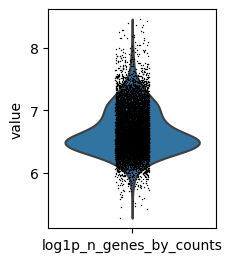

In [89]:
sc.pl.violin(adata_spl_,
             keys='log1p_n_genes_by_counts'
            )

In [94]:
adata_spl_.obs.log1p_n_genes_by_counts.mean()

6.661608894574313

In [95]:
temp_.obs.log1p_n_genes_by_counts.mean()

6.731484336365435

In [79]:
temp = sc.read_h5ad('singlets_spl_PBMC_merged_new.h5ad')

In [96]:
temp_

AnnData object with n_obs × n_vars = 9395 × 70335
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal', 'celltype', 'n_genes_by_counts', 'log1p_n

In [83]:
temp_ = temp[temp.obs.batch == '22']

In [85]:
sc.pp.calculate_qc_metrics(temp_,inplace=True)

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


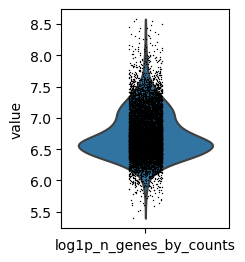

In [90]:
sc.pl.violin(temp_,
             keys='log1p_n_genes_by_counts'
            )

In [60]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [37]:
# adata_spl_.write_h5ad('singlets_spl_PBMC_merged_new.h5ad')

# Plot CD45 example

In [41]:
# adata_spl_merged = sc.read_h5ad('singlets_spl_PBMC_merged.h5ad')
# adata_spl_5p = sc.read_h5ad('singlets_spl_PBMC_5prime.h5ad')

In [43]:
CD45_juncs = [i for i in adata_spl_merged.var_names if i.startswith('PTPRC_')]

In [44]:
merged_juncs = [i for i in adata_spl_merged.var_names if i.startswith('PTPRC_')]

junc_counts_merged = sc.get.obs_df(adata_spl_merged,
              keys=[*CD45_juncs]
             )

In [45]:
fivep_juncs =  [i for i in adata_spl_5p.var_names if i.startswith('PTPRC_')]

junc_counts_5p = sc.get.obs_df(adata_spl_5p,
              keys=[*fivep_juncs]
             )

In [46]:
junc_counts_5p['batch'] = '5prime'
junc_counts_merged['batch'] = 'merged'

In [47]:
juncframe =pd.concat([junc_counts_5p, junc_counts_merged])

In [48]:
juncframe = juncframe.fillna(0)

In [ ]:
df_j

In [50]:
# juncframe_ = juncframe[df_juncs_['index']]

In [52]:
# juncframe_.batch = juncframe['batch']

In [53]:
# sns.boxplotjuncframe_

AttributeError: module 'seaborn' has no attribute 'boxplotjuncframe_'

In [54]:
df_juncs = pd.concat([junc_counts_5p.sum(axis=0),junc_counts_merged.sum(axis=0)],axis=1)

df_juncs.columns = ['5prime', 'SLR']

df_juncs = df_juncs.fillna(0)

df_juncs = df_juncs.sort_index()

df_juncs = df_juncs.reset_index()

In [55]:
df_juncs[['junc_start','junc_end']] = df_juncs['index'].str.split(':',expand=True)[1].str.split('-',expand=True)

In [56]:
# get all junctions within coordinates 198692374-198703297

In [66]:
 # df_juncs= df_juncs.iloc[:-1]

In [68]:
df_juncs_ = df_juncs[(df_juncs.junc_start.astype(int) >= 198692374) & (df_juncs.junc_end.astype(int) <= 198703297)]

In [70]:
break


SyntaxError: 'break' outside loop (370545404.py, line 1)

<Axes: xlabel='level_0', ylabel='0'>

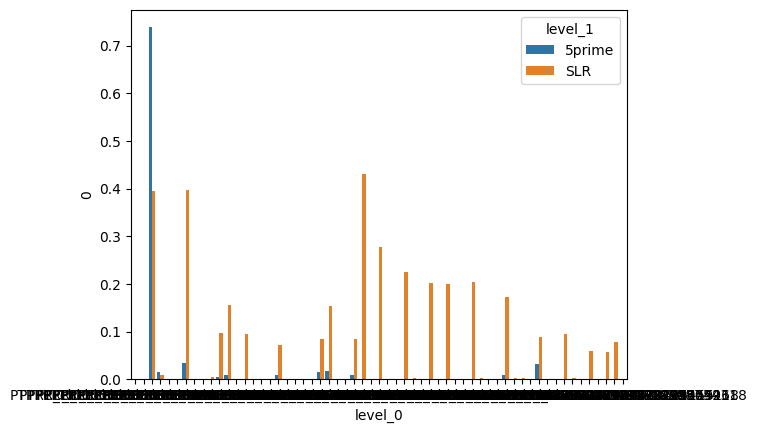

In [60]:
sns.barplot(
            # data = df_juncs.stack().reset_index(), 
           x=df_juncs.stack().reset_index()['level_0'],
           y=df_juncs.stack().reset_index()[0],
            hue=df_juncs.stack().reset_index()['level_1'],
           )

In [ ]:
# adata_spl.write_h5ad(output_dir +'_adata_spl_merged_shared.h5ad')

In [ ]:
break

In [ ]:
#sc.pp.calculate_qc_metrics(adata_spl,inplace=True)

In [ ]:
#adata_spl.var_names_make_unique()

In [ ]:
##calculate PSI per batch separately for memory cap 
adatas_spl = {}

for batch in adata_spl.obs.batch.cat.categories:
    adata_batch = adata_spl[adata_spl.obs['batch'] == batch]
    
    adata_batch.layers["PSI_raw"] = calculate_PSI(adata_batch)
    
    adatas_spl[batch] = adata_batch

adata_spl = anndata.concat(adatas_spl, index_unique="-", merge="same")

In [ ]:
adata_spl.write_h5ad(output_dir +'adata_spl_new_sample_2.h5ad')

In [ ]:
adata_spl_orig= sc.read_h5ad(output_dir +'adata_spl_orig_sample_2.h5ad')

In [ ]:
import seaborn as sns

In [ ]:
sns.violinplot(np.log10(adata_spl.X.sum(axis=1)))

In [ ]:
temp = pd.concat([pd.DataFrame(adata_spl_orig.X.sum(axis=1)), pd.DataFrame(adata_spl.X.sum(axis=1))],axis=1)

In [ ]:
temp.columns = ['orig','new']

In [ ]:
sns.violinplot(temp)

In [ ]:
adata_spl_orig.X.sum(axis=1).mean()


In [ ]:
adata_spl.X.sum(axis=1).mean()

### Generate matrix for 5' reads only for comparisons

In [ ]:
input_dir = "/nowakowskilab/data1/derek/data_scSLR/PBMC/STAR_outs/"

In [ ]:
adatas_spl_5prime = {}
samples = ["sample_1", "sample_2"]
for sample in samples:
    print(sample)
    try:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/StarOut_5prime/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    except:
        adata_spl_sample = load_adata_from_starsolo(input_dir+f"/{sample}/StarOut_5prime/Solo.out/SJ/raw/", var_filename="SJ.out.tab")
    adatas_spl_5prime[sample] = adata_spl_sample

In [ ]:
adatas_spl_5prime = anndata.concat(adatas_spl_5prime, index_unique="-", merge="same")
adatas_spl_5prime

In [ ]:
##fix obs names
adatas_spl_5prime.obs_names = adatas_spl_5prime.obs_names.str.replace('-sample_1','-0').str.replace('-sample_2','-1')



In [ ]:
adatas_spl_5prime = adatas_spl_5prime[adata_exp.obs.index.values]
adatas_spl_5prime.obs = adata_exp.obs
adatas_spl_5prime.obsm["X_umap"] = adata_exp.obsm["X_umap"]
adatas_spl_5prime

In [ ]:
%%time
SJ_table = {}

samples = ["sample_1", "sample_2"]
for sample in samples:
    print(sample)
    try:
        SJ_table_sample = pd.read_csv(input_dir+f"/{sample}/StarOut_5prime/SJ.out.tab",sep='\t',header=None,
                            names=['chromosome','start','end','strand','intron_motif','annotated','coverage','multi_map_coverage','max_ovehang'])
    except:
        SJ_table_sample = pd.read_csv(input_dir+f"/{sample}/StarOut_5prime/SJ.out.tab_new",sep='\t',header=None,
                            names=['chromosome','start','end','strand','intron_motif','annotated','coverage','multi_map_coverage','max_ovehang'])
        
    
    SJ_table[sample] = SJ_table_sample

In [ ]:
SJ_table_df = pd.concat(SJ_table.values(), ignore_index=True)

SJ_table_df = SJ_table_df.groupby(['chromosome','start','end','strand','intron_motif','annotated']).agg({'coverage':'sum', 
                         'multi_map_coverage':'max', 
                         'max_ovehang':'max',})  

SJ_table_df=SJ_table_df.reset_index()

SJ_table_df_bac = SJ_table_df.copy()

SJ_table_df = SJ_table_df[SJ_table_df['coverage'] >= 100]

SJ_table_df.index = SJ_table_df['chromosome']+':'+SJ_table_df['start'].astype(str)+'-'+SJ_table_df['end'].astype(str)

In [ ]:
SJ_table_df.shape

In [ ]:
adata_spl_5prime = adatas_spl_5prime[:,adatas_spl_5prime.var_names.isin(SJ_table_df.index)]

In [ ]:
sc.pp.filter_genes(adatas_spl_5prime, min_cells=1)
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
adatas_spl_5prime = adatas_spl_5prime[:, adatas_spl_5prime.var.chromosome.isin(chromosomes)]

In [ ]:
%%time
##add annotations

gtf_path = '/c4/home/derek/data1/derek/reference/human_hp3_reference/genes/genes.gtf'
filter_unique_gene=True
    
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    header=None,
    comment="#",
    names=[
        "chromosome",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

gtf = gtf[gtf.feature == "exon"]
gtf["gene_id"] = gtf.attribute.str.extract(r'gene_id "([^;]*)";')
gtf["gene_name"] = gtf.attribute.str.extract(r'gene_name "([^;]*)";')
#gtf.chromosome = "chr" + gtf.chromosome.astype(str)

gene_id_name = gtf[["gene_id", "gene_name"]].drop_duplicates()

exon_starts = (
    gtf[["chromosome", "start", "gene_id"]].copy().rename(columns={"start": "pos"})
)
exon_starts.pos -= 1
exon_ends = (
    gtf[["chromosome", "end", "gene_id"]].copy().rename(columns={"end": "pos"})
)
exon_ends.pos += 1
exon_boundaries = pd.concat(
    [exon_starts, exon_ends], ignore_index=True
).drop_duplicates()

genes_by_exon_boundary = exon_boundaries.groupby(
    ["chromosome", "pos"]
).gene_id.unique()

adatas_spl_5prime.var = (
    adatas_spl_5prime.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "start"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_start"})
    .set_index(adatas_spl_5prime.var.index)
)
adatas_spl_5prime.var = (
    adatas_spl_5prime.var.merge(
        genes_by_exon_boundary,
        how="left",
        left_on=["chromosome", "end"],
        right_on=["chromosome", "pos"],
    )
    .rename(columns={"gene_id": "gene_id_end"})
    .set_index(adatas_spl_5prime.var.index)
)

def fill_na_with_empty_array(val):
    return val if isinstance(val, np.ndarray) else np.array([])

adatas_spl_5prime.var.gene_id_start = adatas_spl_5prime.var.gene_id_start.apply(fill_na_with_empty_array)
adatas_spl_5prime.var.gene_id_end = adatas_spl_5prime.var.gene_id_end.apply(fill_na_with_empty_array)

adatas_spl_5prime.var["gene_id_list"] = adatas_spl_5prime.var.apply(
    lambda row: np.unique(np.concatenate([row.gene_id_start, row.gene_id_end])),
    axis=1,
)
adatas_spl_5prime.var["n_genes"] = adatas_spl_5prime.var.gene_id_list.apply(len)
adatas_spl_5prime.var.gene_id_list = adatas_spl_5prime.var.gene_id_list.apply(
    lambda x: ",".join(x.tolist())
)
adatas_spl_5prime.var.gene_id_start = adatas_spl_5prime.var.gene_id_start.apply(
    lambda x: ",".join(x.tolist())
)
adatas_spl_5prime.var.gene_id_end = adatas_spl_5prime.var.gene_id_end.apply(
    lambda x: ",".join(x.tolist())
)

if filter_unique_gene:
    print("Filtering to introns associated to 1 and only 1 gene.")
    adatas_spl_5prime = adatas_spl_5prime[:, adatas_spl_5prime.var.n_genes == 1]
    adatas_spl_5prime.var["gene_id"] = adatas_spl_5prime.var.gene_id_list
    adatas_spl_5prime.var.drop(columns=["gene_id_list",], inplace=True)
    adatas_spl_5prime.var = adatas_spl_5prime.var.merge(gene_id_name, how="left", on="gene_id").set_index(
        adatas_spl_5prime.var.index
    )
    adatas_spl_5prime.var.index = adatas_spl_5prime.var.gene_name.astype(str) + "_" + adatas_spl_5prime.var.index.astype(str)

In [ ]:
adatas_spl_5prime

In [ ]:
adatas_spl_5prime_3p = group_introns(adatas_spl_5prime.copy(), by="three_prime")
adatas_spl_5prime_3p.var["grouping"] = "three_prime"
adatas_spl_5prime_3p

In [ ]:
adatas_spl_5prime_5p = group_introns(adatas_spl_5prime.copy(), by="five_prime")
adatas_spl_5prime_5p.var["grouping"] = "five_prime"
adatas_spl_5prime_5p

In [ ]:
var_concat = pd.concat([adatas_spl_5prime_3p.var, adatas_spl_5prime_5p.var])
keep_5p = var_concat[~var_concat.index.duplicated()].query('grouping == "five_prime"').index.values

In [ ]:
adatas_spl_5prime = anndata.concat(
    [adatas_spl_5prime_3p, filter_singletons(adatas_spl_5prime_5p[:, keep_5p])],
    axis=1,
    merge="same",
)
adatas_spl_5prime

In [ ]:
adatas_spl_5prime.write_h5ad(output_dir+'5prime_adata_spl_v2.h5ad')

In [ ]:
!conda list